# Deep Q-Learning

In [1]:
#!pip install gymnasium[box2d]
#!pip install tqdm
#!pip install imageio

In [2]:
import gymnasium as gym

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from collections import deque
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

import glob
import cv2
import imageio

In [3]:
def render(img: np.array, title: str) -> None:
    clear_output(wait=True)
    plt.axis("off")

    if title != '':
        plt.title(title)

    plt.imshow(img)
    plt.show()


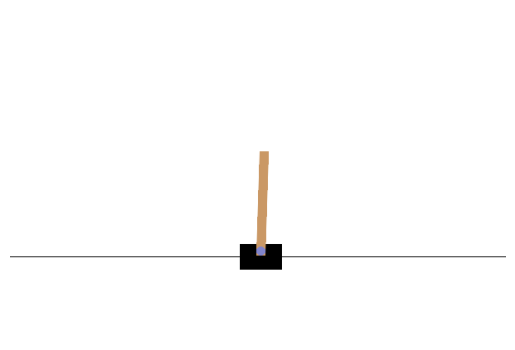

Number of actions: 2 
Number of observations: 4 



In [4]:
env= gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=42)
render(env.render(), '')
env.close()


print("Number of actions: {} \nNumber of observations: {} \n".format(env.action_space.n,env.observation_space.shape[0]))

del env, observation, info

In [5]:
EPISODES = 400
MAX_MEM_LEN = 5_000
LEARNING_RATE = 1e-3

UPDATE_TARGET_NETWORK = 200
MIN_OBSERVATIONS = 1_500
BATCH_LEN = 256

GAMMA = 0.9

MIN_EPSILON = 0.05
EPSILON_DECAY = 0.9995

PRINT_LAPSE =  5

In [6]:
class DQN():
    Epsilon = 1
    steps = 0
    max_score = 0

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    color = (0, 0, 0) #Black
    thickness = 1
    
    def __init__(self, Load_model = False) -> None:
        self.env = gym.make("CartPole-v1", render_mode="rgb_array")

        self.Num_actions = self.env.action_space.n
        self.Num_observations = self.env.observation_space.shape[0]

        self.Q_network = self._create_model()
        if Load_model:
            self._load_weights()

        self.Target_network = self._create_model()
        self._set_Target_weights()

        self.memory = deque(maxlen=MAX_MEM_LEN)

    def _load_weights(self):

        try:
            reward = 0
            for i in glob.glob("./weights/model_weights_*"):
                if i.split('_')[-1] != 'last' and int(i.split('_')[-1]) >= reward :
                    reward = int(i.split('_')[-1]) 
                    weights = i
            self.Q_network.load_weights(weights.replace("\\", "/") + '/weights')
        except:
            print("No weights to load")
        
    def _create_model(self, verbose = False):
        model = Sequential([
            Dense(24,input_shape = (1,self.Num_observations), activation = 'relu', kernel_initializer = tf.keras.initializers.HeNormal()),
            Dense(12, activation = 'relu', kernel_initializer = tf.keras.initializers.HeNormal()),
            Dense(self.Num_actions, activation = 'linear', kernel_initializer = tf.keras.initializers.HeNormal())
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss = 'mse', metrics=['accuracy'])

        if verbose:
            print(model.summary())
        return model

    def _set_Target_weights(self):
        """Set weights of Target network as the Q network"""
        self.Target_network.set_weights(self.Q_network.get_weights())

    def _get_action(self, state: np.array):
        """Select an action based on epsilon-greedy exploration strategy"""

        if self.Epsilon > random.random():
            return self.env.action_space.sample()
        
        return np.argmax(self.Q_network.predict(state, verbose = 0))
    
    def Experience_replay(self):
        
        if len(self.memory) >= MIN_OBSERVATIONS:

            states, actions, rewards, dones, next_states = zip(*random.sample(self.memory, BATCH_LEN))

            states = tf.reshape(tf.convert_to_tensor(states), [BATCH_LEN,1, self.Num_observations])
            next_states = tf.reshape(tf.convert_to_tensor(next_states), [BATCH_LEN,1, self.Num_observations])

            Q_values = self.Q_network.predict( states , verbose = 0 , batch_size = BATCH_LEN)
            next_Q_values = self.Target_network.predict( next_states , verbose = 0, batch_size = BATCH_LEN)

            for i in range(BATCH_LEN):
                Q_values[i][0][ actions[i] ] = rewards[i] + GAMMA * np.amax( next_Q_values[i] ) if not dones[i] else rewards[i]
            
            self.Q_network.fit(states, Q_values, batch_size=(BATCH_LEN), epochs = 1, verbose = 0)

            del states, actions, rewards, dones, next_states, Q_values, next_Q_values

    def Train(self):
        scores = []
        
        for epoch in range(EPISODES):
            
            state, _  = self.env.reset()
            state = np.array([[state]])
            score = 0

            while True:
                
                #With probability \epsilon select random action 
                action = self._get_action(state)

                #Execute action in emulator and observe reward and next_state
                next_state, reward, done, _, _ =self.env.step(action)
                next_state = np.array([[next_state]])

                #Store transition in memory
                if len(self.memory) < MAX_MEM_LEN:
                    self.memory.append([state,action, reward, done, next_state])
                else:
                    #Randomly put new data in memory
                    erase = random.randint(0, MAX_MEM_LEN - 1)
                    self.memory[erase] = [state,action, reward, done, next_state]

                #Update every 4 steps
                if self.steps % 4 == 0:
                    #Use Experience replay to fit the network
                    self.Experience_replay()
                
                self.Epsilon = max(self.Epsilon * EPSILON_DECAY, MIN_EPSILON)

                state = next_state
                score += reward

                self.steps += 1

                #Update Target network weights
                if self.steps % UPDATE_TARGET_NETWORK == 0 and len(self.memory) > MIN_OBSERVATIONS:
                    self._set_Target_weights()

                if done or self.steps % random.randint(180,400) == 0:
                    break
            
            if score >=  self.max_score:
                self.max_score = score
                self.Q_network.save_weights('./weights/model_weights_{}_{}/weights'.format(self.steps, int(score)))
                print("New High Score: {}, Step: {}".format(score, self.steps))

            if epoch % 10 == 0:
                print(f"Run: {epoch}, Score: {score}, Epsilon: {self.Epsilon}, Total Steps: {self.steps}")
                scores.append(score)
        
        pop = np.arange(1,len(scores)*PRINT_LAPSE,PRINT_LAPSE)

        plt.bar(pop, scores, color = 'b', width=3)
        plt.plot(pop, scores, color = 'r')
        plt.xticks(pop)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid('on')

        self.Q_network.save_weights('./weights/model_weights_last/weights')

    def _load_paths(self,) -> None:
        paths = []

        for path in glob.glob('./weights/model_weights_*'):
            if path.split('_')[-1] != 'last':
                paths.append((path, int(path.split('_')[-1])))

        paths.sort(key=lambda x: x[1], reverse=True)

        paths.insert(0,('./weights/model_weights_last', 0))  

        return paths

    def _saveanimation(self, frames, address):
        """ 
        This method ,given the frames of images make the gif and save it in the folder
        
        params:
            frames:method takes in the array or np.array of images
            address:(optional)given the address/location saves the gif on that location
                    otherwise save it to default address './movie.gif'
        
        return :
            none
        """
        imageio.mimsave(address, frames)

    def Test(self, tests_number, show_render = False):
        
        paths = self._load_paths()[:tests_number]
        imgs = []

        self.Epsilon = MIN_EPSILON
        for path, _ in paths:
            self.Q_network.load_weights(path + '/weights')
            
            state, _  = self.env.reset()
            state = np.array([[state]])
            score = 0

            while True:
                
                #With probability \epsilon select random action 
                action = self._get_action(state)

                #Execute action in emulator and observe reward and next_state
                next_state, reward, done, _, _ =self.env.step(action)
                next_state = np.array([[next_state]])

                score += reward
                state = next_state

                if done:
                    break

                if score > 200:
                    break
                else:
                    img = self.env.render()
                    
                    img = cv2.putText(img, 'Weights: {}'.format(path.split('_')[-2:] ), (10, 30), self.font, 
                                      self.fontScale, self.color, self.thickness, cv2.LINE_AA)
                    img = cv2.putText(img, 'Score: {}'.format(score), (10, 65), self.font, 
                                      self.fontScale, self.color, self.thickness, cv2.LINE_AA)
                    imgs.append(img)
                    if show_render:
                        render(img, "{} Score: {}".format(path,score))

        self._saveanimation(imgs, './images/test.gif')



In [7]:
dqn = DQN(True)

New High Score: 25.0, Step: 25
Run: 0, Score: 25.0, Epsilon: 0.9875747132889687, Total Steps: 25
New High Score: 50.0, Step: 75
Run: 10, Score: 15.0, Epsilon: 0.8807057004226791, Total Steps: 254
Run: 20, Score: 17.0, Epsilon: 0.79807205286414, Total Steps: 451
Run: 30, Score: 23.0, Epsilon: 0.6913616081308254, Total Steps: 738
Run: 40, Score: 19.0, Epsilon: 0.6388331068556816, Total Steps: 896
Run: 50, Score: 14.0, Epsilon: 0.5771590383046616, Total Steps: 1099
Run: 60, Score: 17.0, Epsilon: 0.5201367977132525, Total Steps: 1307
Run: 70, Score: 17.0, Epsilon: 0.48013717428461355, Total Steps: 1467
New High Score: 64.0, Step: 1581
Run: 80, Score: 14.0, Epsilon: 0.43595878531621046, Total Steps: 1660
Run: 90, Score: 12.0, Epsilon: 0.4117982129747795, Total Steps: 1774
Run: 100, Score: 11.0, Epsilon: 0.3913180673523923, Total Steps: 1876
Run: 110, Score: 9.0, Epsilon: 0.3677874521460121, Total Steps: 2000
Run: 120, Score: 12.0, Epsilon: 0.3474048938787229, Total Steps: 2114
Run: 130, Sco

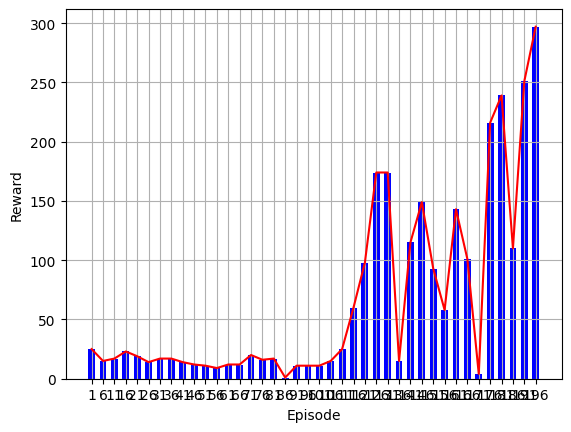

In [8]:
dqn.Train()

In [9]:
NUMBER_TESTS = 3

dqn.Test(NUMBER_TESTS, show_render = False)